In [8]:
import numpy as np
import pandas as pd
import os

### Download videos for training

Downloads videos as mp4 and saves the audio as mp3. mp4 may or may not contain audio due to the API being limited, though this should not matter (except for the small negative impact on file size). Currently videos are being downloaded in 720p since 1080p is inconsistent/bugged.

In [9]:
from pytube import YouTube 
  
urls = ["https://www.youtube.com/watch?v=Yt3-a9mExZg", "https://www.youtube.com/watch?v=cGt8bEcd9Ms"]
pathVideo = 'Data/Video'
pathAudio = 'Data/Audio'

for i, url in enumerate(urls):
    yt = YouTube(url)
    yt.streams.filter(abr="160kbps", progressive=False).first().download(filename="Audio"+str(i)+".mp3", output_path = pathAudio)
    yt.streams.filter(res="720p", progressive=False).first().download(filename="Video"+str(i)+".mp4", output_path= pathVideo)
##

### Split video into frames

Goes through each downloaded video. Creates a directory per video inside 'tempFrames' and then saves the frames here. We can set the amount of frames we want per minute. Note that file sizes of these images can balloon quickly, exceeding the filesize of the video itself.

This code is mainly for early testing

In [10]:
import cv2
FRAMES_PER_MINUTE = 10
frame_counter = 60000 / FRAMES_PER_MINUTE
pathVideo = 'Data/Video/'
videoNames = []
for filename in os.listdir(pathVideo):
    f = os.path.join(pathVideo, filename)
    if os.path.isfile(f):
        if filename != '.gitignore':
            videoNames.append(filename)

for video in videoNames:
    path = pathVideo + video
    outputPath = 'Data/tempFrames/' + video[:-4] + '/' ## make directory per video
    if not os.path.exists(outputPath):
        os.mkdir(outputPath)
        print(f'Created new dir {outputPath}')
    vidcap = cv2.VideoCapture(pathVideo + video)
    success,image = vidcap.read()
    print(f'Succesful videocapture?: {success}')
    count = 0
    while success:
        cv2.imwrite(outputPath + "%d_seconds.jpg" % (count*(frame_counter/1000)), image)     # save frame as JPEG file   
        count += 1
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_counter))   
        success,image = vidcap.read()
        

Succesful videocapture?: True
Succesful videocapture?: True


### Py-Feat

This library provides a pipeline containing multiple models related to facial detection. The most interesting aspect here is the output of AU's (action units), which will be a key part of predicting interest levels.

While the library works okay, it has difficulties with cuda and the documentation is lacking. The goal here is to use feat-py for prototyping and then later create a similar pipeline myself. This gives me more possibilities in for example fine-tuning, while also giving more control with regards to memory management and gpu usage. 

Action units cheat-sheet: https://py-feat.org/pages/au_reference.html

In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import feat
from feat.facepose_detectors.img2pose.img2pose_test import Img2Pose
import torch
from torchvision import transforms
from PIL import Image
convert_tensor = transforms.ToTensor()

In [18]:
detector = feat.detector.Detector(face_model='img2pose-c', facepose_model='img2pose-c')
imclassifier = Img2Pose(constrained=1, detection_threshold=0.25, rpn_pre_nms_top_n_test=2000, rpn_post_nms_top_n_test=200)

In [30]:
results = pd.DataFrame(columns=['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight', 'FaceScore', 'pos1', 'pos2', 'pos3'])
print(imclassifier)
img = Image.open("Data/testImages/ac3.jpg")
img = convert_tensor(img)
pred = imclassifier.scale_and_predict(img)
for i in range(len(pred['boxes'])):
    pass

0
1
2


100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,AU43,anger,disgust,fear,happiness,sadness,surprise,neutral,input,frame
0,194.0,146.0,323.0,404.0,0.998609,209.916895,210.452200,214.772693,225.211363,244.714768,...,0.196123,0.000080,0.000020,0.000913,0.996819,0.000823,0.001337,0.000009,Data/testImages/ac3.jpg,0
1,886.0,391.0,81.0,92.0,0.997096,898.632428,898.760057,899.587928,901.371516,905.108943,...,0.015913,0.003714,0.001013,0.000094,0.954536,0.010575,0.000226,0.029841,Data/testImages/ac3.jpg,0
2,876.0,25.0,141.0,169.0,0.993822,902.735971,899.178718,896.796341,896.476818,898.891771,...,0.057714,0.001399,0.000065,0.001886,0.924839,0.000454,0.004658,0.066699,Data/testImages/ac3.jpg,0


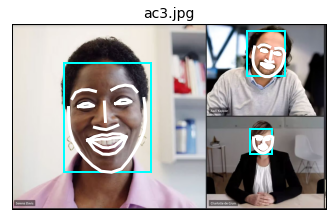

In [19]:
from feat.utils.io import get_test_data_path
from feat.plotting import imshow

# Helper to point to the test data folder
test_data_dir = get_test_data_path()

# Get the full path
single_face_img_path = os.path.join(test_data_dir, "single_face.jpg")

#single_face_prediction = detector.detect_image(single_face_img_path)
single_face_prediction = detector.detect_image('Data/testImages/ac3.jpg')

# Show results
single_face_prediction.plot_detections(au_barplot=False, emotion_barplot=False)
single_face_prediction

In [6]:
from feat.utils.io import get_test_data_path
import os

test_data_dir = get_test_data_path()
test_video_path = os.path.join(test_data_dir, "WolfgangLanger_Pexels.mp4")
# test_video_path = "Data/Video/Video1.mp4"

# Show video
# from IPython.core.display import Video
# Video(test_video_path, embed=False)

In [7]:
video_prediction = detector.detect_video(test_video_path, skip_frames=1)
video_prediction.head()

100%|██████████| 472/472 [13:52<00:00,  1.76s/it]


,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,AU43,anger,disgust,fear,happiness,sadness,surprise,neutral,input,frame
frame,,,,,,,,,,,,,,,,,,,,,
0,319.720117,55.237810,216.000698,292.068049,0.997603,329.962411,330.437781,334.496893,341.875740,352.322015,...,0.255497,0.002501,0.001239,0.000651,0.019328,0.824563,0.000482,0.151236,c:\Users\Ramon\AppData\Local\Programs\Python\P...,0
1,330.866881,57.511112,205.630385,290.787716,0.997717,329.885388,330.354873,334.248931,341.594880,352.164196,...,0.244137,0.005560,0.002230,0.001015,0.044167,0.573243,0.000722,0.373064,c:\Users\Ramon\AppData\Local\Programs\Python\P...,1
2,320.265960,55.663170,214.787779,288.873493,0.999215,333.192423,333.510114,337.431230,344.478401,354.379050,...,0.220537,0.002962,0.000897,0.000750,0.016465,0.808555,0.000359,0.170012,c:\Users\Ramon\AppData\Local\Programs\Python\P...,2
3,322.048828,54.473926,212.685324,290.192369,0.998270,329.300534,329.899806,333.964125,341.212140,351.567292,...,0.214754,0.001817,0.001107,0.000644,0.014285,0.891465,0.000191,0.090490,c:\Users\Ramon\AppData\Local\Programs\Python\P...,3
4,321.551925,56.897859,212.392997,286.385038,0.998291,330.937149,331.315629,335.204381,342.412757,352.802413,...,0.200508,0.000980,0.000954,0.000776,0.003423,0.973815,0.000120,0.019932,c:\Users\Ramon\AppData\Local\Programs\Python\P...,4


In [45]:
video_prediction

,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,AU43,anger,disgust,fear,happiness,sadness,surprise,neutral,input,frame
frame,,,,,,,,,,,,,,,,,,,,,
0,319.720117,55.237810,216.000698,292.068049,0.997603,329.962411,330.437781,334.496893,341.875740,352.322015,...,0.255497,0.002501,0.001239,0.000651,0.019328,0.824563,0.000482,0.151236,c:\Users\Ramon\AppData\Local\Programs\Python\P...,0
24,336.741964,60.797419,206.634319,281.743457,0.992118,345.702502,344.232902,345.704215,350.447882,359.773877,...,0.405968,0.004090,0.027869,0.000608,0.009565,0.948194,0.000152,0.009522,c:\Users\Ramon\AppData\Local\Programs\Python\P...,24
48,335.276842,36.169618,210.273884,293.163138,0.999868,335.765001,332.492291,331.874926,333.715917,341.089311,...,0.176430,0.001263,0.006532,0.000689,0.001800,0.979605,0.000068,0.010044,c:\Users\Ramon\AppData\Local\Programs\Python\P...,48
72,302.344950,57.305253,217.691713,299.283866,0.999384,309.737437,309.087152,311.556439,317.623455,328.490236,...,0.576938,0.015221,0.002093,0.001747,0.002838,0.950352,0.000250,0.027500,c:\Users\Ramon\AppData\Local\Programs\Python\P...,72
96,327.340960,96.704771,204.161942,305.480469,0.975764,310.576479,310.436690,312.635542,318.210954,329.804322,...,0.681028,0.020859,0.153740,0.006339,0.001399,0.801509,0.002115,0.014039,c:\Users\Ramon\AppData\Local\Programs\Python\P...,96
120,338.385938,89.846540,198.589565,292.037081,0.999180,341.808417,347.665890,355.915402,364.707212,375.737685,...,0.318203,0.003347,0.004165,0.013773,0.000428,0.964834,0.004328,0.009126,c:\Users\Ramon\AppData\Local\Programs\Python\P...,120
144,339.935184,45.089858,203.371624,302.776046,0.998253,338.269154,337.235091,340.481809,347.834678,357.888248,...,0.099196,0.000328,0.006550,0.544275,0.000103,0.440943,0.005115,0.002686,c:\Users\Ramon\AppData\Local\Programs\Python\P...,144
168,322.278571,35.137074,212.069308,288.947719,0.999999,322.492517,321.725296,324.565370,330.882461,340.081637,...,0.052377,0.000826,0.001146,0.307978,0.001015,0.634183,0.023076,0.031776,c:\Users\Ramon\AppData\Local\Programs\Python\P...,168
192,337.482506,26.252405,205.469280,295.585932,0.999889,328.802734,327.824728,330.728412,337.955751,348.209398,...,0.357925,0.000159,0.000453,0.873908,0.000418,0.087825,0.024471,0.012766,c:\Users\Ramon\AppData\Local\Programs\Python\P...,192


### Face detection

The goal here is to detect a face in a video and track its location with a bounding box
The code is moved to face_tracking_persistence.py


### Video segmentation

To reduce memory usage it could be worthwile to only work with the video data inside of bounding boxes. I experimented with this in face_tracking_persistency.py

### Audio analysis

Removed the code for now, as I will be focusing on video during this project. Audio could potentially still play a part, but unlikely.